Saving current notebook before running...
THD (100 Hz): 0.28%
THD (200 Hz): 0.14%
THD (300 Hz): 0.09%
THD (400 Hz): 0.07%
THD (500 Hz): 0.06%
THD (600 Hz): 0.05%
THD (700 Hz): 0.05%
THD (800 Hz): 0.05%
THD (900 Hz): 0.04%
THD (1000 Hz): 0.05%
THD (1100 Hz): 0.04%
THD (1200 Hz): 0.04%
THD (1300 Hz): 0.04%
THD (1400 Hz): 0.04%
THD (1500 Hz): 0.03%
THD (1600 Hz): 0.03%
THD (1700 Hz): 0.04%
THD (1800 Hz): 0.03%
THD (1900 Hz): 0.02%
THD (2000 Hz): 0.02%
THD (2100 Hz): 0.03%
THD (2200 Hz): 0.04%
THD (2300 Hz): 0.03%
THD (2400 Hz): 0.04%
THD (2500 Hz): 0.03%
THD (2600 Hz): 0.04%
THD (2700 Hz): 0.03%
THD (2800 Hz): 0.04%
THD (2900 Hz): 0.03%
THD (3000 Hz): 0.04%
THD (3100 Hz): 0.03%
THD (3200 Hz): 0.05%
THD (3300 Hz): 0.02%
THD (3400 Hz): 0.02%
THD (3500 Hz): 0.03%
THD (3600 Hz): 0.03%
THD (3700 Hz): 0.03%
THD (3800 Hz): 0.03%
THD (3900 Hz): 0.01%
THD (4000 Hz): 0.04%
THD (4100 Hz): 0.02%
THD (4200 Hz): 0.03%
THD (4300 Hz): 0.03%
THD (4400 Hz): 0.03%
THD (4500 Hz): 0.03%
THD (4600 Hz): 0.02%
T

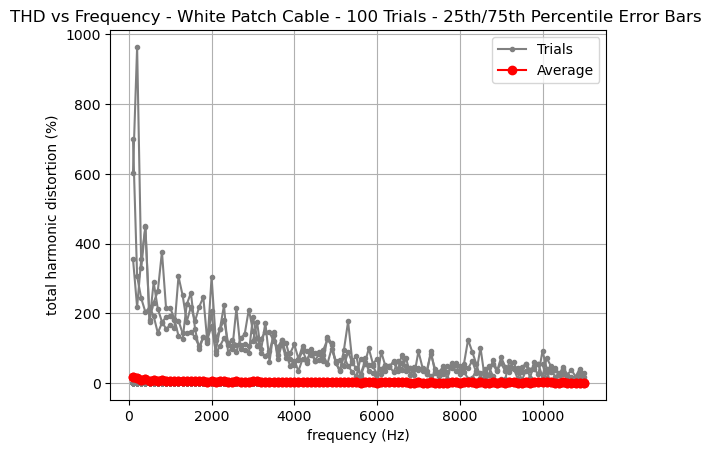

In [273]:
import numpy as np
import matplotlib.pyplot as plt
import math
import time
import sys
import sounddevice as sd
# import subprocess
# import pyaudio

from scipy.io import savemat

import git 
import os
from ipylab import JupyterFrontEnd

try:
    # Save file in Jupyter Notebook before execution and commit to Git repo
    app = JupyterFrontEnd()
    app.commands.execute('docmanager:save')
    print('Saving current notebook before running...')
    time.sleep(1)
except:
    print('An error occured while automatically saving file.')

# Generate tone
# fc_approx = 8000 # approximate fc, will choose fc to be a factor of fs, will analyze 1 second of data, so this should be an integer
fs = 44.1e3

# experiment settings
numTrials = 100
# deviceUnderTest = 'THD Triad 80043 RevD' # used as file prefix for saved data and corresponding plots
deviceUnderTest = 'White Patch Cable' # used as file prefix for saved data and corresponding plots
deviceUnderTestUS = deviceUnderTest.replace(" ", "-")

# tone generation settings
duration = 1.5 # in seconds
toneAmplitude = .56 # gain factor, need to appropriately set to avoid clipping
minFreqToTest = 100.0 # in Hz
maxFreqToTest = fs/4 # in Hz
freqSpacing = 100.0 # in Hz

# analysis settings
fundFreqNotchWidthFract = .1 # width of the brick wall notch filter in frequency domain when measuring distortion expressed as a fraction of the fundamental frequency
fundFreqSearchWidthFract = .01 # width of the range to search for max amplitude relative to fundamental frequency
startBuffer = 0.25 # number of seconds from beginning of recorded file to ignore
endBuffer = 0.25 # number of seconds from end of recorded file to ignore
    
# archive code state for this experiment
try:
    changedFiles = [item.a_path for item in currRepo.index.diff(None)]
    currRepo.git.add(changedFiles)
    currRepo.index.commit(f'Experiment execution\n \
    Device: {deviceUnderTest}\n \
    # Trials: {numTrials}\n \
    \n \
    Generation Settings:\n \
    \tTone amplitude: {toneAmplitude}\n \
    \tDuration: {duration} seconds\n \
    \tSampling frequency: {fs} Hz\n \
    \tMin Frequency: {minFreqToTest} Hz\n \
    \tMax frequency: {maxFreqToTest} Hz\n \
    \tFrequency spacing: {freqSpacing} Hz\n \
    \n \
    Analysis Settings:\n \
    \tFundamental frequency notch width (fraction of center frequency): {fundFreqNotchWidthFract}\n \
    \tFundamental frequency search width (fraction of center frequency): {fundFreqSearchWidthFract}\n \
    \tTime ignored at beginning of recording: {startBuffer} seconds\n \
    \tTime ignored at end of recording: {endBuffer} seconds\n \
    \tResuling DFT bin size: {fs/((duration-startBuffer-endBuffer)*fs)} Hz\n \
    ')
    # currRepo.remote.origin.push() # push to origin
except:
    print('An error occured while automatically commiting to Git repository.')

# gitShortHash = subprocess.check_output('git rev-parse --short HEAD').strip().decode()
currRepo = git.Repo(os.getcwd())
sha = currRepo.head.commit.hexsha
short_sha = currRepo.git.rev_parse(sha, short=7)
# assert no currRepo.is_dirty()

# raise Exception('I am tired')

# execution settings
debugOn = False
savedDataFilePrefix = f'{deviceUnderTestUS}_{short_sha}'

freqsToTest =  np.arange(minFreqToTest,maxFreqToTest,freqSpacing) #np.array([7100]) #np.arange(100,fs/4,1000) #
thdAll = np.zeros((freqsToTest.shape[0],numTrials))

for trialIdx in range(0,numTrials):
    for freqIdx in range(0,len(freqsToTest)):
        print(f'Trial {trialIdx+1}/{numTrials}')
        fc = freqsToTest[freqIdx]
        # fc = fs/round(fs/fc_approx)
        # bufferSize = 512

        t = np.arange(0,duration,1/fs)
        signalOrig = toneAmplitude * np.sin(2*math.pi*fc*t)
        # tone1 = toneAmplitude * np.sin(2*math.pi*fc*1*t)
        # tone2 = toneAmplitude * np.sin(2*math.pi*fc*2*t)
        # tone3 = toneAmplitude * np.sin(2*math.pi*fc*3*t)
        # signalOrig = tone1 + tone2 + tone3

        # # Add synthetic distortion
        # maxHarmonic = math.floor(fs/2/fc)
        # harmonicCoeff = 1e-4*np.random.rand(maxHarmonic-1)

        # signalDistortions = np.zeros(signalOrig.shape)
        # for harmNum in range(2,maxHarmonic):
        #     signalDistortions = signalDistortions + harmonicCoeff[harmNum-2]*np.sin(2*math.pi*fc*t*harmNum)

        # signalToAnalyze = signalOrig + signalDistortions

        # Playback and record signal
        signalToAnalyzeRaw = sd.playrec(signalOrig, fs, channels=1)
        sd.wait()

        signalToAnalyze = signalToAnalyzeRaw[math.ceil(startBuffer*fs):(len(signalToAnalyzeRaw)-math.ceil(endBuffer*fs))]
        #savemat('recSig.mat',{'y':signalToAnalyze,'fs':fs,'tone1':tone1,'tone2':tone2,'tone3':tone3})

        # measure spectrum
        spectrum = np.fft.rfft(signalToAnalyze,axis=0)
        fftBin = fs/len(signalToAnalyze)
        # freqX = np.arange(-fs/2,fs/2,fftBin)

        fcIdxTheoretical = round(fc/fftBin)
        fcOffcenter = fc/fftBin - fcIdxTheoretical

        if fcOffcenter > 1e-3:
            print("DFT bin not centered on carrier frequency. Unexpected results may occur due to spectral leakage.")

        fundFreqSearchWidthHz = fundFreqSearchWidthFract*fc # Hz, width of the brick wall notch filter in frequency domain when measuring distortion
        fundFreqSearchWidthHzSamps = fundFreqSearchWidthHz/fftBin
        fundFreqSearchWidthHzSampsHW = int(np.ceil(fundFreqSearchWidthHzSamps/2)) # round up
        minSearchIdx = int(np.max([0,fcIdxTheoretical-fundFreqSearchWidthHzSampsHW]))
        maxSearchIdx = int(np.min([len(spectrum)-1,fcIdxTheoretical+fundFreqSearchWidthHzSampsHW])) 
        fcIdx = int(minSearchIdx + np.argmax(abs(spectrum[minSearchIdx:maxSearchIdx])))
        # savemat('recSig.mat',{'fundFreqSearchWidthFract':fundFreqSearchWidthFract,\
        #                       'fcIdxTheoretical':fcIdxTheoretical,\
        #                       'freqSpectrum':spectrum,\
        #                       'fs':fs,\
        #                       'minSearchIdx':minSearchIdx,\
        #                       'maxSearchIdx':maxSearchIdx,\
        #                       'fcIdx':fcIdx,\
        #                       'fundFreqSearchWidthHz':fundFreqSearchWidthHz,\
        #                       'fundFreqSearchWidthHzSamps':fundFreqSearchWidthHzSamps,\
        #                       'fundFreqSearchWidthHzSampsHW':fundFreqSearchWidthHzSampsHW})
        if debugOn:
            print(f'Correct fcIdx by %d DFT bins' % (fcIdxTheoretical-fcIdx))

        carrierAmpl = abs(spectrum[fcIdx][0])

        if np.mod(len(spectrum),2)==0: # even number of points in spectrum
            lastPosFreqIdx = int((fs/2)/fftBin)
        else: # odd number of points in spectrum
            lastPosFreqIdx = int((fs/2 - fftBin)/fftBin)

        # measure power of all signals other than the fundamental frequency
        spectrumNoFund = spectrum.copy()

        # apply "brick wall" notch filter in spectrum (i.e. zero out frequency components around fundamental frequency
        fundFreqNotchWidthHz = fundFreqNotchWidthFract*fc # Hz, width of the brick wall notch filter in frequency domain when measuring distortion
        fundFreqNotchWidthHzSamps = fundFreqNotchWidthHz/fftBin
        fundFreqNotchWidthHzSampsHW = int(np.ceil(fundFreqNotchWidthHzSamps/2)) # round up
        minNotchIdx = int(np.max([0,fcIdx-fundFreqNotchWidthHzSampsHW]))
        maxNotchIdx = int(np.min([len(spectrumNoFund),fcIdx+fundFreqNotchWidthHzSampsHW]))
        spectrumNoFund[minNotchIdx:maxNotchIdx] = 0

        harmonicAmpl = np.sqrt(np.sum(np.square(abs(spectrumNoFund))))

        # measure power of harmonics signals of the fundamental frequency
        harmonicIdx = range(2*fcIdx,lastPosFreqIdx,fcIdx)
        harmonicAmpl = np.sqrt(np.sum(np.square(abs(spectrum[harmonicIdx]))))

        measTHD = harmonicAmpl/carrierAmpl*100
        print("\tTHD (%d Hz): %.2f%%" % (fc,measTHD))
        # print("freqIdx: %d" % (freqIdx))
        thdAll[freqIdx][trialIdx] = measTHD

        if debugOn:
            # Plot time domain signal
            plt.plot(signalToAnalyze[0:int(10/fc*fs-1)])
            plt.title(f'Recorded Signal %d Hz' % fc)
            plt.xlabel('time (samples)')
            plt.ylabel('magnitude')
            plt.grid(visible=True,which='both',axis='both')
            plt.show()

            # Plot positive frequency spectrum showing fundamental frequency
            freqX = np.fft.fftfreq(len(signalToAnalyze), d=1./fs)
            if np.mod(len(spectrum),2)==0: # even number of points in spectrum
                freqXPos = np.arange(0,int(fs/2),int(fftBin))
            else: # odd number of points in spectrum
                freqXPos = np.arange(0,int(fs/2-fftBin),int(fftBin))
            # plt.plot(freqXPos,abs(spectrum[range(0,len(freqXPos))]))
            # plt.plot(freqXPos[fcIdx],abs(spectrum[fcIdx]),marker="*")
            # plt.plot(freqXPos[harmonicIdx],abs(spectrum[harmonicIdx]),linestyle='None',marker="o")
            plt.plot(freqXPos,20*np.log10(abs(spectrum[range(0,len(freqXPos))])))
            plt.plot(freqXPos[fcIdx],20*np.log10(abs(spectrum[fcIdx])),marker="*")
            plt.plot(freqXPos[harmonicIdx],20*np.log10(abs(spectrum[harmonicIdx])),linestyle='None',marker='o')
            plt.title(f'Recorded Signal Spectrum %d Hz' % fc)
            plt.xlabel('frequency (Hz)')
            plt.grid(visible=True,which='both',axis='both')
            plt.show()

            # Plot positive frequency spectrum removing fundamental frequency
            # plt.plot(freqXPos,abs(spectrumNoFund[range(0,len(freqXPos))]))
            # plt.plot(freqXPos[fcIdx],abs(spectrumNoFund[fcIdx]),marker="*")
            # plt.plot(freqXPos[harmonicIdx],abs(spectrumNoFund[harmonicIdx]),linestyle='None',marker="o")
            plt.plot(freqXPos,20*np.log10(abs(spectrumNoFund[range(0,len(freqXPos))])))
            plt.plot(freqXPos[fcIdx],20*np.log10(abs(spectrumNoFund[fcIdx])),marker="*")
            plt.plot(freqXPos[harmonicIdx],20*np.log10(abs(spectrumNoFund[harmonicIdx])),linestyle='None',marker='o')
            plt.title(f'Recorded Signal Spectrum %d Hz - Fundamental Removed' % fc)
            plt.xlabel('frequency (Hz)')
            plt.grid(visible=True,which='both',axis='both')
            plt.show()

        time.sleep(.5)
        savemat(f'{savedDataFilePrefix}.mat',{'freqsToTest':freqsToTest,\
                             'thdAll':thdAll,\
                             'toneAmplitude':toneAmplitude,\
                             'fundFreqNotchWidthFract':fundFreqNotchWidthFract,\
                             'fundFreqSearchWidthFract':fundFreqSearchWidthFract,\
                             'deviceUnderTest':deviceUnderTest,\
                             'fs':fs,\
                             'startBuffer':startBuffer,\
                             'endBuffer':endBuffer,\
                             'sha':sha,\
                             'numTrials':numTrials}) # save results after every trial in case experiment is interrupted
        
# Plot each trial as a separate line graph
plotDesc = 'linePerTrialWAvg'
thdAvg = np.average(thdAll,axis=1)
for trialIdx in range(0,numTrials):
    # plt.plot(freqsToTest,thdAll[:,trialIdx],'k',label=f'Trial {trialIdx+1}')
    lh, = plt.plot(freqsToTest,thdAll[:,trialIdx],marker='.',color=(.5,.5,.5))
lh.set_label('Trials')
plt.plot(freqsToTest,thdAvg,'r-',marker='o',label='Average')
plt.legend()
plt.title(f'THD vs Frequency - {deviceUnderTest} - {numTrials} Trials')
plt.xlabel('frequency (Hz)')
plt.ylabel('total harmonic distortion (%)')
plt.grid(visible=True,which='both',axis='both')
plt.savefig(f'{savedDataFilePrefix}_{plotDesc}.png', bbox_inches='tight')
plt.show()

# Make single line graph with error bars at the 25th and 75th percentiles
plotDesc = 'lineErrorBars'
thdAvg = np.average(thdAll,axis=1)
thd75 = np.percentile(thdAll,75,axis=1)
thd25 = np.percentile(thdAll,25,axis=1)
thdErr = np.stack((thd25,thd75),axis=0)
plt.errorbar(freqsToTest,thdAvg,yerr=thdErr,ecolor='grey',color='r',marker='o')
plt.title(f'THD vs Frequency - {deviceUnderTest} - {numTrials} Trials - 25th/75th Percentile Error Bars ')
plt.xlabel('frequency (Hz)')
plt.ylabel('total harmonic distortion (%)')
plt.grid(visible=True,which='both',axis='both')
plt.savefig(f'{savedDataFilePrefix}_{plotDesc}.png', bbox_inches='tight')


In [272]:
# Find maximum amplitude of tone, output linear chirp multiple times and check for saturation
fs = 44.1e3

# Experiment settings
minFreqToTest = 100.0 # in Hz
maxFreqToTest = fs/4 # in Hz
duration = 15 # in seconds
numTrials = 10 # number of chirps output during single recording
minAmpToTest = .5
maxAmptToTest = 2
amplitudeDigitsPrecision = 2

amplitudeIncr = .1 

# Analysis settings
startBuffer = 0.25 # number of seconds from beginning of recorded file to ignore
endBuffer = 0.25 # number of seconds from end of recorded file to ignore
saturationThreshold = .95
numSampsAtSatToAllow = 100

# Execution settings
debugOn = False

# derive additional static values from configuration settings
timePerChirp = duration/numTrials
chirpRate = (maxFreqToTest-minFreqToTest)/timePerChirp
t = np.arange(0,duration,1/fs)

# initialize loop variables
notSaturated = True
toneAmplitude = minAmpToTest
sampsAboveSatTHPrevToneAmp = 0

while notSaturated and (toneAmplitude <= maxAmptToTest):
    print(f'Testing tone amplitude {toneAmplitude}...')
    signalOrig = toneAmplitude * np.sin(2*math.pi*chirpRate*t**2)
    
    # Playback and record signal
    signalToAnalyzeRaw = sd.playrec(signalOrig, fs, channels=1)
    sd.wait()
    signalToAnalyze = signalToAnalyzeRaw[math.ceil(startBuffer*fs):(len(signalToAnalyzeRaw)-math.ceil(endBuffer*fs))]

    # Check for saturation (values with magnitude near 1)
    sampsAboveSatTH = np.sum(abs(signalToAnalyze)>saturationThreshold)
    if sampsAboveSatTH > numSampsAtSatToAllow:
        print(f'\tSATURATED at {toneAmplitude}.\n\
        \t{sampsAboveSatTH} samples above saturation threshold ({saturationThreshold})')
        
        # if level of desired precision is not reached yet, then back off on
        # the amplitude by one increment and continue the search at greater level of precision        
        if amplitudeIncr > 10**(-amplitudeDigitsPrecision):
            toneAmplitude = toneAmplitude - amplitudeIncr
            amplitudeIncr = amplitudeIncr/10
            print(f'\tResetting amplitude to {toneAmplitude} and decreasing increment to {amplitudeIncr}')
        else:        
            notSaturated = False
            print(f'\tMax tone amplitude is: {toneAmplitude-amplitudeIncr}\n\
            \t{sampsAboveSatTHPrevToneAmp} samples above saturation threshold ({saturationThreshold})')
    else:
        print('\tnot saturated')
    sampsAboveSatTHPrevToneAmp = sampsAboveSatTH
    
    # if debugOn:
    #     # Plot time domain signal
    #     plt.plot(signalToAnalyze[0:int(10/fc*fs-1)])
    #     plt.title(f'Recorded Signal %d Hz' % fc)
    #     plt.xlabel('time (samples)')
    #     plt.ylabel('magnitude')
    #     plt.grid(visible=True,which='both',axis='both')
    #     plt.show()

    #     # Plot spectrogram
    #     freqRes = (maxFreqToTest - minFreqToTest)/10
    #     sampsPerFFTApprox = fs/freqRes            
    #     sampsPerFFT = int(2**np.ceil(np.log2(sampsPerFFTApprox))) # round up to power of 2
    #     overlapRatio = 0
    #     overlapSamps = int(sampsPerFFT*overlapRatio) # will always be integer since FFT size is even
    #     savemat('recSig.mat',{'signalToAnalyze':signalToAnalyze,\
    #                           'fs':fs,\
    #                           'sampsPerFFT':sampsPerFFT,\
    #                           'overlapSamps':overlapSamps})
    #     plt.specgram(signalToAnalyze,NFFT=sampsPerFFT,Fs=fs,noverlap=overlapSamps)
    #     # # Plot positive frequency spectrum showing fundamental frequency
    #     # freqX = np.fft.fftfreq(len(signalToAnalyze), d=1./fs)
    #     # if np.mod(len(spectrum),2)==0: # even number of points in spectrum
    #     #     freqXPos = np.arange(0,int(fs/2),int(fftBin))
    #     # else: # odd number of points in spectrum
    #     #     freqXPos = np.arange(0,int(fs/2-fftBin),int(fftBin))
    #     # # plt.plot(freqXPos,abs(spectrum[range(0,len(freqXPos))]))
    #     # # plt.plot(freqXPos[fcIdx],abs(spectrum[fcIdx]),marker="*")
    #     # # plt.plot(freqXPos[harmonicIdx],abs(spectrum[harmonicIdx]),linestyle='None',marker="o")
    #     # plt.plot(freqXPos,20*np.log10(abs(spectrum[range(0,len(freqXPos))])))
    #     # plt.plot(freqXPos[fcIdx],20*np.log10(abs(spectrum[fcIdx])),marker="*")
    #     # plt.plot(freqXPos[harmonicIdx],20*np.log10(abs(spectrum[harmonicIdx])),linestyle='None',marker='o')
    #     # plt.title(f'Recorded Signal Spectrum %d Hz' % fc)
    #     # plt.xlabel('frequency (Hz)')
    #     # plt.grid(visible=True,which='both',axis='both')
    #     # plt.show()
    toneAmplitude = toneAmplitude + amplitudeIncr

Testing tone amplitude 0.5...
	not saturated
Testing tone amplitude 0.6...
	SATURATED at 0.6.
        	50159 samples above saturation threshold (0.95)
	Resetting amplitude to 0.5 and decreasing increment to 0.01
Testing tone amplitude 0.51...
	not saturated
Testing tone amplitude 0.52...
	not saturated
Testing tone amplitude 0.53...
	not saturated
Testing tone amplitude 0.54...
	not saturated
Testing tone amplitude 0.55...
	not saturated
Testing tone amplitude 0.56...
	not saturated
Testing tone amplitude 0.5700000000000001...
	SATURATED at 0.5700000000000001.
        	176 samples above saturation threshold (0.95)
	Max tone amplitude is: 0.56
            	0 samples above saturation threshold (0.95)
